# DNN Classification with Tensorflow

## Imports & initialization

In [4]:
# import the libraries we will use
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# an utility function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [6]:
# internalize the dataset
df = pd.read_csv('Churn.csv',sep=',')

In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Split into training & testing data

In [8]:
# Separete the input data and the value to predict (the 'Exited' column).
# By convention: X is the input data and Y is the value to predict.
x_data = df.drop(['Exited'],axis=1)
y_val = df['Exited']

In [9]:
# Separate the dataset in two parts:
# 70% of the data will be used for training the model
# 30% to test it
X_train, X_test, y_train, y_test = train_test_split(x_data,y_val,test_size=0.3,random_state=101)

In [10]:
# X_train.describe()

### Scale the data

In [11]:
cols_to_scale=['CreditScore','Tenure','Balance','NumOfProducts','EstimatedSalary']

In [12]:
# Get around a bug in Sklearn / Pandas communication
# see https://stackoverflow.com/questions/45090639/pandas-shows-settingwithcopywarning-after-train-test-split
X_train.is_copy=None
X_test.is_copy=None

In [13]:
# X_train.head()

In [14]:
for col in cols_to_scale:
    xmin=X_train[col].min()
    dx=X_train[col].max()-xmin
    X_train[[col]] = X_train[[col]].apply(lambda x: ((x - xmin) / dx))
    X_test[[col]] = X_test[[col]].apply(lambda x: ((x - xmin) / dx))

In [15]:
X_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
803,804,15712825,Howells,0.322,Spain,Female,29,0.9,0.000000,0.333333,0,1,0.703471
1387,1388,15674526,Byrne,0.750,France,Male,66,0.4,0.344601,0.000000,1,1,0.707469
921,922,15743411,Chiawuotu,0.518,Spain,Male,61,0.1,0.000000,0.000000,1,0,0.112204
5917,5918,15812184,Rose,0.648,France,Female,31,0.1,0.000000,0.000000,1,0,0.644844
9610,9611,15812534,Chiemenam,0.210,France,Male,40,0.1,0.000000,0.666667,0,1,0.649952


In [16]:
# X_train.describe()

## Create the tensorflow estimator

### Create the 'feature columns'

In [17]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [18]:
# create the numeric columns
age = tf.feature_column.numeric_column('Age')
creditscore = tf.feature_column.numeric_column('CreditScore')
tenure = tf.feature_column.numeric_column('Tenure')
balance = tf.feature_column.numeric_column('Balance')
numproducts = tf.feature_column.numeric_column('NumOfProducts')
hascard = tf.feature_column.numeric_column('HasCrCard')
isactive = tf.feature_column.numeric_column('IsActiveMember')
estimated = tf.feature_column.numeric_column('EstimatedSalary')

In [19]:
# create categorical columns
geography = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Geography',vocabulary_list=df['Geography'].unique()))
gender = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Gender',vocabulary_list=df['Gender'].unique()))

In [20]:
# X_train['Age'].hist(bins=75)

In [21]:
# Discretize the age column 
age_b = tf.feature_column.bucketized_column(age, boundaries=[20,30,40,50,60,70,80])

In [22]:
feat_cols = [age_b,creditscore,tenure,balance,numproducts,hascard,isactive,estimated,geography,gender ]

### Create the input functions

In [23]:
# A first input function for training: feed the model with the training data & result
train_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [24]:
# A second input function for testing: feed the model with the test data
test_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      num_epochs=1,
      shuffle=False)

In [25]:
# another input function on the trainign set to get some stats on the training set on it
valid_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_train,
      num_epochs=1,
      shuffle=False)

### Create the estimator and train it

In [135]:
# Create a neural network with 3 layers of 10 neurons each
model = tf.estimator.DNNClassifier(hidden_units=[4,1],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_log_step_count_steps': 100, '_model_dir': '/var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None}


In [136]:
#reset errors 
err=[]
err2=[]

In [137]:
for i in range(1,51):
    #train
    model.train(input_fn=train_input_fn,steps=700)
    #test and get the confusion matrix on test
    predictions = list(model.predict(test_input_func))
    y_pred = []
    for p in predictions:
        y_pred.append(p['class_ids'][0])
    cmp=confusion_matrix(y_test, y_pred)
    err.append((cmp[0,1]+cmp[1,0])/30)
    #Get it on the training set
    predictions2 = list(model.predict(valid_input_func))
    y_pred2 = []
    for p in predictions2:
        y_pred2.append(p['class_ids'][0])
    cmp2=confusion_matrix(y_train, y_pred2)
    err2.append((cmp2[0,1]+cmp2[1,0])/70)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:step = 1, loss = 11.656
INFO:tensorflow:global_step/sec: 109.903
INFO:tensorflow:step = 101, loss = 4.2815 (0.918 sec)
INFO:tensorflow:global_step/sec: 167.424
INFO:tensorflow:step = 201, loss = 6.13055 (0.605 sec)
INFO:tensorflow:global_step/sec: 192.263
INFO:tensorflow:step = 301, loss = 5.74387 (0.514 sec)
INFO:tensorflow:global_step/sec: 213.136
INFO:tensorflow:step = 401, loss = 4.52339 (0.460 sec)
INFO:tensorflow:global_step/sec: 166.087
INFO:tensorflow:step = 501, loss = 5.01212 (0.606 sec)
INFO:tensorflow:global_step/sec: 168.703
INFO:tensorflow:step = 601, loss = 4.58011 (0.614 sec)
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 4.04896.
INFO:tensorflow:Restoring parameters from /var/folders/

INFO:tensorflow:step = 4401, loss = 4.52105 (0.517 sec)
INFO:tensorflow:global_step/sec: 219.718
INFO:tensorflow:step = 4501, loss = 1.89573 (0.462 sec)
INFO:tensorflow:global_step/sec: 218.803
INFO:tensorflow:step = 4601, loss = 4.57022 (0.458 sec)
INFO:tensorflow:global_step/sec: 191.77
INFO:tensorflow:step = 4701, loss = 1.67354 (0.522 sec)
INFO:tensorflow:global_step/sec: 188.441
INFO:tensorflow:step = 4801, loss = 8.5256 (0.531 sec)
INFO:tensorflow:Saving checkpoints for 4900 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 6.4002.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-4900
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-4900
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.

INFO:tensorflow:global_step/sec: 202.459
INFO:tensorflow:step = 9001, loss = 1.56574 (0.486 sec)
INFO:tensorflow:Saving checkpoints for 9100 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 2.7049.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-9100
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-9100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-9100
INFO:tensorflow:Saving checkpoints for 9101 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:step = 9101, loss = 5.54646
INFO:tensorflow:global_step/sec: 196.775
INFO:tensorflow:step = 9201, loss = 4.03139 (0.512 sec)
INFO:tensorflow:global_step/sec: 216.556
INFO:tensorflow:step = 9301, lo

INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-13300
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-13300
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-13300
INFO:tensorflow:Saving checkpoints for 13301 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:step = 13301, loss = 1.13236
INFO:tensorflow:global_step/sec: 182.436
INFO:tensorflow:step = 13401, loss = 3.16679 (0.547 sec)
INFO:tensorflow:global_step/sec: 221.758
INFO:tensorflow:step = 13501, loss = 4.13105 (0.450 sec)
INFO:tensorflow:global_step/sec: 156.576
INFO:tensorflow:step = 13601, loss = 1.16932 (0.652 sec)
INFO:tensorflow:global_step/sec: 173.891
INFO:tensorflow:step = 13701, loss = 2.25461 (0.563 sec)
INFO:tensorflow:global_step/sec: 191

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-17500
INFO:tensorflow:Saving checkpoints for 17501 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:step = 17501, loss = 3.26884
INFO:tensorflow:global_step/sec: 202.861
INFO:tensorflow:step = 17601, loss = 2.05145 (0.494 sec)
INFO:tensorflow:global_step/sec: 241.754
INFO:tensorflow:step = 17701, loss = 1.1464 (0.414 sec)
INFO:tensorflow:global_step/sec: 153.939
INFO:tensorflow:step = 17801, loss = 3.55218 (0.656 sec)
INFO:tensorflow:global_step/sec: 198.97
INFO:tensorflow:step = 17901, loss = 3.78658 (0.503 sec)
INFO:tensorflow:global_step/sec: 196.644
INFO:tensorflow:step = 18001, loss = 5.52567 (0.509 sec)
INFO:tensorflow:global_step/sec: 176.56
INFO:tensorflow:step = 18101, loss = 4.51213 (0.567 sec)
INFO:tensorflow:Saving checkpoints for 18200 into /var/folders/2c/gpl2fhbx4kgft314v

INFO:tensorflow:step = 21701, loss = 8.4213
INFO:tensorflow:global_step/sec: 165.804
INFO:tensorflow:step = 21801, loss = 4.00928 (0.611 sec)
INFO:tensorflow:global_step/sec: 187.806
INFO:tensorflow:step = 21901, loss = 1.73436 (0.538 sec)
INFO:tensorflow:global_step/sec: 207.965
INFO:tensorflow:step = 22001, loss = 3.24496 (0.472 sec)
INFO:tensorflow:global_step/sec: 213.847
INFO:tensorflow:step = 22101, loss = 7.2448 (0.465 sec)
INFO:tensorflow:global_step/sec: 218.436
INFO:tensorflow:step = 22201, loss = 2.9635 (0.460 sec)
INFO:tensorflow:global_step/sec: 221.688
INFO:tensorflow:step = 22301, loss = 2.13872 (0.452 sec)
INFO:tensorflow:Saving checkpoints for 22400 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 4.16014.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-22400
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq

INFO:tensorflow:global_step/sec: 219.801
INFO:tensorflow:step = 26201, loss = 4.84569 (0.455 sec)
INFO:tensorflow:global_step/sec: 206.155
INFO:tensorflow:step = 26301, loss = 4.40597 (0.493 sec)
INFO:tensorflow:global_step/sec: 195.816
INFO:tensorflow:step = 26401, loss = 2.9752 (0.510 sec)
INFO:tensorflow:global_step/sec: 181.746
INFO:tensorflow:step = 26501, loss = 3.7417 (0.552 sec)
INFO:tensorflow:Saving checkpoints for 26600 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 4.1709.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-26600
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-26600
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-26600
INFO:tensorflow:Saving checkpoints for

INFO:tensorflow:step = 30601, loss = 6.84685 (0.586 sec)
INFO:tensorflow:global_step/sec: 184.478
INFO:tensorflow:step = 30701, loss = 4.25666 (0.545 sec)
INFO:tensorflow:Saving checkpoints for 30800 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:Loss for final step: 2.70779.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-30800
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-30800
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-30800
INFO:tensorflow:Saving checkpoints for 30801 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt.
INFO:tensorflow:step = 30801, loss = 2.62638
INFO:tensorflow:global_step/sec: 173.907
INFO:tensorflow:step = 30901, loss = 5.53964 (0.577 sec)
INFO:t

INFO:tensorflow:Loss for final step: 3.65124.
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-35000
INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpke3sjfld/model.ckpt-35000


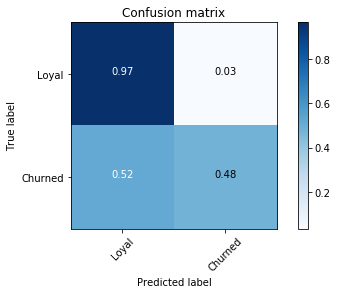

In [138]:
plot_confusion_matrix(cmp,["Loyal","Churned"],True)

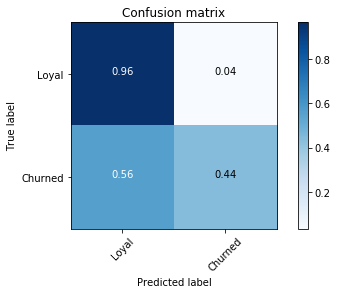

In [139]:
plot_confusion_matrix(cmp2,["Loyal","Churned"],True)

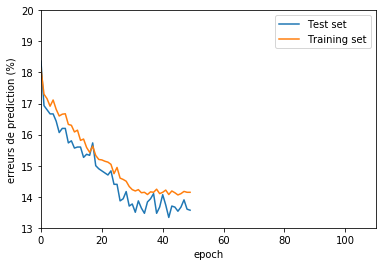

In [140]:
plt.plot(err,label="Test set")
plt.plot(err2,label="Training set")
plt.autoscale(True)
plt.xlabel("epoch")
plt.ylabel("erreurs de prediction (%)")
plt.legend()
plt.xlim(0,110)
plt.ylim(13,20)
plt.autoscale(False)

In [126]:
err


[17.300000000000001,
 17.166666666666668,
 16.966666666666665,
 17.0,
 16.699999999999999,
 16.666666666666668,
 16.733333333333334,
 16.666666666666668,
 16.233333333333334,
 15.966666666666667,
 16.033333333333335,
 16.233333333333334,
 15.966666666666667,
 15.633333333333333,
 15.433333333333334,
 15.4,
 15.566666666666666,
 15.366666666666667,
 15.233333333333333,
 15.199999999999999,
 15.1,
 15.066666666666666,
 15.066666666666666,
 15.033333333333333,
 14.9,
 14.933333333333334,
 14.9,
 14.833333333333334,
 15.066666666666666,
 14.733333333333333,
 14.666666666666666,
 14.733333333333333,
 14.699999999999999,
 14.699999999999999,
 14.466666666666667,
 14.5,
 14.666666666666666,
 14.5,
 14.166666666666666,
 14.666666666666666,
 14.1,
 14.533333333333333,
 14.433333333333334,
 14.066666666666666,
 14.366666666666667,
 14.166666666666666,
 14.133333333333333,
 14.266666666666667,
 14.133333333333333,
 14.066666666666666,
 14.1,
 14.033333333333333,
 14.133333333333333,
 13.966666666

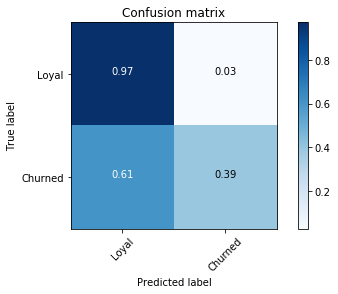

In [74]:
plot_confusion_matrix(cmp2,["Loyal","Churned"],True)